# Quadcopter 6DOF Simulation

A nonlinear 6 degree-of-freedom simulation of a quadcopter.

The following are some of the assumptions made in this simulation:
* Rigid body dynamics
* Products of inertia are all zero due to symmetry of vehicle
* Simplified rotor aerodynamics based on actuator disk theory
  + Assumes rigid propellers
  + 1-D, incompressible flow
  + Uniform airflow over disk representing area of propeller travel
  + No downwash or airflow interference from nearby structure
  + Angle of attack is assumed to be within linear lift coefficient region
  + Small angle approximation applied for angle of attack
  + Propeller blade angle linearly twists from root to tip
* No delays or motor dynamics are included, motor commands achieve desired RPM instantaneously

### Simulation Settings

This first cell will hold the user defined parameters:  
* Configuration and weights of the quadcopter
* Simulation time settings
* Initial conditions

In [57]:
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


# Physical Constants
m = 0.1         #kg
Ixx = 0.00062   #kg-m^2
Iyy = 0.00113   #kg-m^2
Izz = 0.9*(Ixx + Iyy) #kg-m^2 (Assume nearly flat object, z=0)
dx = 0.114      #m
dy = 0.0825     #m
g = 9.81  #m/s/s
DTR = 1/57.3; RTD = 57.3


# Simulation time and model parameters
tstep = 0.02            # Sampling time (sec)
simulation_time = 30   # Length of time to run simulation (sec)
t = np.arange(0,simulation_time,tstep)   # time array

# Model size
n_states = 12  # Number of states
n_inputs = 4   # Number of inputs


# Initialize State Conditions
x = np.zeros((n_states,np.size(t)))  # time history of state vectors
# Initial height
x[11,0] = 0.0


# Initialize inputs
u = np.zeros((n_inputs,np.size(t)))  # time history of input vectors
# Initial control inputs
u[:,0] = np.zeros(4)


## Aerodynamics Model

### Propeller Thrust

Using actuator disk theory, which assumes airflow is constant throughout the disk representing the travel of the propeller blades.


**Calculate induced velocity ($v_i$) and thrust (T) by solving the system of 3 equations:**  

Local airstream velocity at center of propeller  
$V' = \sqrt{ U^2 + V^2 + (W - v_i)^2}$  

Total thrust of propeller using local angle of attack where propeller twist is assumed to be linear from root to tip, and averaged over one revolution:  
$T = \frac{1}{4}\rho abcR [(W - v_i) \Omega R + \frac{2}{3}(\Omega R)^2(\theta_0+\frac{3}{4}\theta_1) + (U^2+V^2)(\theta_0 + \frac{1}{2}\theta_1) ]$ 

Thrust equals the change in velocity times the mass flow rate   
$T = \eta 2v_i\rho A V'$

**where:**  

[U,V,W] = Longitudinal, lateral, and vertical components of local airstream velocity  
$v_i$ = induced velocity generated by propeller  
A = area of disk  
$\rho$ = density of air  
a = lift curve slope $(\frac{dC_L}{d\alpha})$  
b = number of propeller blades  
c = mean chord length of propeller blades  
R = propeller blade length (radius of disk)  
$\Omega$ = Angular rate of propeller rotation  
$\theta_0$ = propeller pitch angle at root  
$\theta_1$ = delta pitch twist at propeller tip (assumes linear twist along blade)  
$\eta$ = effeciency of propeller (value of 0-1)

### Propeller Normal Force

Propellers will also produce a normal force, perpendicular to the thrust force. This is not currently modeled.

### Gyroscopic Force

The yawing moment from the propellers will come from the gyroscopic force of the rotating motors and propellers. This is not currently modeled.  
  
---
***Reference:*** *Stevens, B., Lewis, F., and Johnson, E., Aircraft Control and Simulation: Dynamics, Controls Design, and Autonomous Systems. 3rd ed., John Wiley & Sons, 2016.*  
  (Note: topic not covered in previous editions)

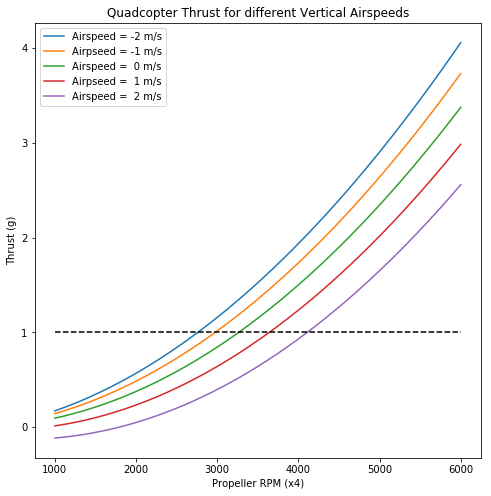

In [58]:
from scipy.optimize import fsolve

# Propeller Thrust equations as a function of propeller induced velocity, vi
def thrustEqn(vi, *prop_params):
    
    # Unpack parameters
    R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega = prop_params
    
    # Calculate local airflow velocity at propeller with vi, V'
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    
    # Calculate Thrust averaged over one revolution of propeller using vi
    Thrust = 1/4 * rho * a * b * c * R * \
        ( (W - vi) * Omega * R + 2/3 * (Omega * R)**2 * (theta0 + 3/4 * theta1) + \
          (U**2 + V**2) * (theta0 + 1/2 * theta1) )
    
    # Calculate residual for equation: Thrust = mass flow rate * delta Velocity
    residual = eta * 2 * vi * rho * A * Vprime - Thrust
    
    return residual

    
def Fthrust(x, u, dx, dy):
    # Inputs: Current state x[k], Commanded Propeller RPM inputs u[k],
    #         Propeller location distances dx, dy (m)
    # Returns: Thrust vector for 4 propellers (Newtons)
    
    # Propeller Configuration parameters
    
    R = 0.0762   # propeller length/ disk radius (m) 
    A = np.pi * R ** 2
    rho = 1.225  #kg/m^3  at MSL
    a = 5.7      # Lift curve slope used in example in Stevens & Lewis
    b = 2        # number of blades
    c = 0.0274   # mean chord length (m)
    eta = 1      # propeller efficiency
    
    # Manufacturer propeller length x pitch specification:
    p_diameter = 6  #inches
    p_pitch = 3   #inches
    
    theta0 = 2*np.arctan2(p_pitch, (2 * np.pi * 3/4 * p_diameter/2))
    theta1 = -4 / 3 * np.arctan2(p_pitch, 2 * np.pi * 3/4 * p_diameter/2)
    
    
    # Local velocity at propeller from vehicle state information
    ub, vb, wb = x[0], x[1], x[2]
    p, q, r = x[3], x[4], x[5]
    # Transofrm velocity to local propeller location:
    #     [U,V,W] = [ub,vb,wb] + [p,q,r] x [dx,dy,0]
    U = ub - r * dy
    V = vb + r * dx
    W = wb - q * dx + p * dy
    
    # Convert commanded RPM to rad/s
    Omega = 2 * np.pi / 60 * u
    
    #Collect propeller config, state, and input parameters
    prop_params = (R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega)
    
    # Numerically solve for propeller induced velocity, vi
    # using nonlinear root finder, fsolve, and prop_params
    vi0 = 0.1    # initial guess for vi
    vi = fsolve(thrustEqn, vi0, args=prop_params)
    
    # Plug vi back into Thrust equation to solve for T
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    Thrust = eta * 2 * vi * rho * A * Vprime
    
    return Thrust

    
# Torque function
def T(F,dx,dy):
    # Returns torque about cg given thrust force and dx,dy distance from cg
    
    #### PLACEHOLDER ####
    return 0


# Plot Thrust as a function of RPM for various vertical velocity conditions
RPM = np.linspace(1000,6000,200)
vertvel = np.array([0,0,1] + 9*[0])
Thrust_m2vel = np.array([Fthrust(2*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_m1vel = np.array([Fthrust(1*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_0vel  = np.array([Fthrust(0*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_p1vel = np.array([Fthrust(-1*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_p2vel = np.array([Fthrust(-2*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
fig = plt.figure(figsize=(8,8))
plt.plot(RPM, 4 * Thrust_m2vel / (m*g) )
plt.plot(RPM, 4 * Thrust_m1vel / (m*g) )
plt.plot(RPM, 4 * Thrust_0vel / (m*g) )
plt.plot(RPM, 4 * Thrust_p1vel / (m*g) )
plt.plot(RPM, 4 * Thrust_p2vel / (m*g) )
plt.plot(RPM, np.ones(np.size(RPM)), 'k--')
plt.legend(('Airspeed = -2 m/s','Airpseed = -1 m/s','Airspeed =  0 m/s', \
            'Airpseed =  1 m/s','Airspeed =  2 m/s'), loc='upper left')
plt.xlabel('Propeller RPM (x4)')
plt.ylabel('Thrust (g)')
plt.title('Quadcopter Thrust for different Vertical Airspeeds')
plt.show()


## Equations of Motion

**Calculate the derivative of the state as a function of the current state and control inputs**

$\dot{u} = -g\sin(\theta) + rv - qw$  

$\dot{v} = g\sin(\phi)\cos(\theta) -ru + pw$  

$\dot{w} = \frac{1}{m}(-F_{z}) + g\cos(\phi)\cos(\theta) + qu - pv$  

$\dot{p} = \frac{1}{I_{xx}}(L + (I_{yy}-I_{zz})qr)$  

$\dot{q} = \frac{1}{I_{yy}}(M + (I_{zz}-I_{xx})pr)$  

$\dot{r} = \frac{1}{I_{zz}}(N + (I_{xx}-I_{yy})pq)$  

$\dot{\phi} = p + (q \sin\phi + r \cos\phi) \tan\theta$  

$\dot{\theta} = q \cos\phi - r \sin\phi$  

$\dot{\psi} = (q \sin\phi + r \cos\phi) \sec\theta$  

$\dot{x}^{E} = c_{\theta}c_{\psi}u^{b} + (-c_{\phi}s_{\psi}+s_{\phi}s_{\theta}c_{\psi})v^{b} + (s_{\phi}s_{\psi}+c_{\phi}s_{\theta}c_{\psi})w^{b}$  

$\dot{y}^{E} = c_{\theta}s_{\psi}u^{b} + (c_{\phi}c_{\psi}+s_{\phi}s_{\theta}s_{\psi})v^{b} + (-s_{\phi}c_{\psi}+c_{\phi}s_{\theta}s_{\psi})w^{b}$  

$\dot{h}^{E} = s_{\theta}u^{b} - s_{\phi}c_{\theta}v^{b} - c_{\phi}c_{\theta}w^{b}$  

**where**

$F_{z} = F_1 + F_2 + F_3 + F_4$  

$L = F_1 d_{1y} - F_2 d_{2y} - F_3 d_{3y} + F_4 d_{4y}$  

$M = F_1 d_{1x} - F_2 d_{2x} + F_3 d_{3x} - F_4 d_{4x}$  

$N = -T(F_1,d_{1x},d_{1y}) - T(F_2,d_{2x},d_{2y}) + T(F_3,d_{3x},d_{3y}) + T(F_4,d_{4x},d_{4y})$  


and $h^E$ is positive in the up direction (increases with negative $w$).

In [59]:
# Nonlinear Dynamics Equations of Motion
def stateDerivative(x,u):
    # Inputs: state vector (x), input vector (u)
    # Returns: time derivative of state vector (xdot)
    
    #  State Vector Reference:
    #idx  0, 1, 2, 3, 4, 5,  6,   7,   8,   9, 10, 11
    #x = [u, v, w, p, q, r, phi, the, psi, xE, yE, hE]
    
    # Store state variables in a readable format
    ub = x[0]
    vb = x[1]
    wb = x[2]
    p = x[3]
    q = x[4]
    r = x[5]
    phi = x[6]
    theta = x[7]
    psi = x[8]
    xE = x[9]
    yE = x[10]
    hE = x[11]
    
    # Calculate forces from propeller inputs (u)
    F1 = Fthrust(x, u[0],  dx,  dy)
    F2 = Fthrust(x, u[1], -dx, -dy)
    F3 = Fthrust(x, u[2],  dx, -dy)
    F4 = Fthrust(x, u[3], -dx,  dy)
    Fz = F1 + F2 + F3 + F4
    L = (F1 + F4) * dy - (F2 + F3) * dy
    M = (F1 + F3) * dx - (F2 + F4) * dx
    N = -T(F1,dx,dy) - T(F2,dx,dy) + T(F3,dx,dy) + T(F4,dx,dy)
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)
    cthe = np.cos(theta); sthe = np.sin(theta)
    cpsi = np.cos(psi);   spsi = np.sin(psi)
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros(12)
    
    xdot[0] = -g * sthe + r * vb - q * wb  # = udot
    xdot[1] = g * sphi*cthe - r * ub + p * wb # = vdot
    xdot[2] = 1/m * (-Fz) + g*cphi*cthe + q * ub - p * vb # = wdot
    xdot[3] = 1/Ixx * (L + (Iyy - Izz) * q * r)  # = pdot
    xdot[4] = 1/Iyy * (M + (Izz - Ixx) * p * r)  # = qdot
    xdot[5] = 1/Izz * (N + (Ixx - Iyy) * p * q)  # = rdot
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot
    
    xdot[9] = cthe*cpsi*ub + (-cphi*spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xEdot
        
    xdot[10] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yEdot
        
    xdot[11] = -1*(-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = hEdot
    
    return xdot




## Control Law

This is a placeholder for where the control law will determine the input commands it sends to the propeller motors.

For now, we can try hard coding in some example open loop control inputs at different times to see how the model dynamics respond.

In [127]:
def controlInputs(x, t):
    # Inputs: Current state x[k], time t
    # Returns: Control inputs u[k]
    
    #### Placeholder Function ####
    
    # Trim RPM for all 4 propellers to provide thrust for a level hover
    trim = 3200
    
    pitch_cmd = 0
    roll_cmd = 0
    climb_cmd = 0
    yaw_cmd = 0
    
    # Example open loop control inputs to test dynamics:
    #  Climb
    if t < 11.0:
        climb_cmd = 500
    
    #  Pitch Forward
    if t > 8.0:
        pitch_cmd = -10
    if t > 9.0:
        pitch_cmd = 10
    if t > 10.0:
        pitch_cmd = 0
    
    #  Pitch Backward
    if t > 12.0:
        pitch_cmd = 15
    if t > 13.0:
        pitch_cmd = -15
    if t > 14.0:
        pitch_cmd = 0
    
    #  Increase lift
    if t > 16.0:
        climb_cmd = 150
        
    
    # RPM command based on pitch, roll, climb, yaw commands
    u = np.zeros(4)
    u[0] = trim + ( pitch_cmd + roll_cmd + climb_cmd - yaw_cmd) / 4
    u[1] = trim + (-pitch_cmd - roll_cmd + climb_cmd - yaw_cmd) / 4
    u[2] = trim + ( pitch_cmd - roll_cmd + climb_cmd + yaw_cmd) / 4
    u[3] = trim + (-pitch_cmd + roll_cmd + climb_cmd + yaw_cmd) / 4
    
    
    return u

## Linearized Equations

Take the nonlinear relationship:  
$ \dot{u} = -g \sin(\theta) + rv - qw $  
<br>
and substitute for each state variable (e.g. $u$) a reference ($U_0$) and perturbation ($\delta u$) variable (e.g. $u = U_0 + \delta u$), then we get:  
$ \dot{(U_0 + \delta u)} = -g \sin(\Theta_0 + \delta \theta) + (R_0 + \delta r)(V_0 + \delta v) - (Q_0 + \delta q)(W_0 + \delta w)$  
<br>
which expands to:  
$ \dot{U_0} + \dot{\delta u} = -g (\sin(\Theta_0)\cos(\delta \theta) + \cos(\Theta_0)\sin(\delta \theta)) + R_0 V_0 + R_0 \delta v + V_0 \delta r + \delta r \delta v - Q_0 W_0 - Q_0 \delta w - W_0 \delta q - \delta q \delta w $  
<br>
To reduce this to a linear form we make the following assumptions:  
* small angle approximation, so $\cos(\theta) \approx 1$ and $\sin(\theta) \approx \theta$
* nonlinear products of perturbation equal zero, so $\delta r \delta v \approx 0$ and $\delta q \delta w \approx 0$  

And the equation simplifies to:  
$ \dot{U_0} + \dot{\delta u} = [-g \sin(\Theta_0) + R_0 V_0 - Q_0 W_0] + [-g \cos(\Theta_0)\delta \theta + R_0 \delta v + V_0 \delta r - Q_0 \delta w - W_0 \delta q] $ 
<br>
It can be seen that the reference variables are equal to the original relationship of the nonlinear equations of motion. If we treat the reference equation as an equilibrium state of the nonlinear system, then we can describe the perturbation about that equilibrium as a set of linear, first order differential equations using only the remaining perturbation variables. In these equations the time-varying states are the delta perturbations from the equilibrium state, and the reference values serve as constant coefficients in the equation.  
<br>
The same process can be done for all of the equations of motion to get the following perturbation equations. I've colored the perturbation variables blue to make the linear relationship easier to see.  

**Perturbations from equilibrium:**

$\dot{\color{blue}{\delta u}} = R_0 \color{blue}{\delta v} - Q_0 \color{blue}{\delta w} - W_0 \color{blue}{\delta q} + V_0 \color{blue}{\delta r} - g\cos(\Theta_0)\color{blue}{\delta \theta} $  

$\dot{\color{blue}{\delta v}} = -R_0 \color{blue}{\delta u} + P_0 \color{blue}{\delta w} + W_0 \color{blue}{\delta p} - U_0 \color{blue}{\delta r} + g\cos(\Phi_0)\cos(\Theta_0)\color{blue}{\delta \phi} - g\sin(\Phi_0)\sin(\Theta_0)\color{blue}{\delta \theta}  $  

$\dot{\color{blue}{\delta w}} = Q_0 \color{blue}{\delta u} - P_0 \color{blue}{\delta v} - V_0 \color{blue}{\delta p} + U_0 \color{blue}{\delta q} + g\sin(\Phi_0)\cos(\Theta_0)\color{blue}{\delta \phi} + g\cos(\Phi_0)\sin(\Theta_0)\color{blue}{\delta \theta} + \frac{1}{m}(-\color{blue}{\delta F_{z}}) $  

$\dot{\color{blue}{\delta p}} = \frac{I_{yy}-I_{zz}}{I_{xx}} R_0 \color{blue}{\delta q} + \frac{I_{yy}-I_{zz}}{I_{xx}} Q_0 \color{blue}{\delta r} + \frac{1}{I_{xx}}\color{blue}{\delta L} $  

$\dot{\color{blue}{\delta q}} = \frac{I_{zz}-I_{xx}}{I_{yy}} R_0 \color{blue}{\delta p} + \frac{I_{zz}-I_{xx}}{I_{yy}} P_0 \color{blue}{\delta r} + \frac{1}{I_{yy}}\color{blue}{\delta M} $  

$\dot{\color{blue}{\delta r}} = \frac{I_{xx}-I_{yy}}{I_{zz}} Q_0 \color{blue}{\delta p} + \frac{I_{xx}-I_{yy}}{I_{zz}} P_0 \color{blue}{\delta q} + \frac{1}{I_{zz}}\color{blue}{\delta N} $  

$\dot{\color{blue}{\delta \phi}} = \color{blue}{\delta p}+ \tan(\Theta_0)\sin(\Phi_0)\color{blue}{\delta q} + \tan(\Theta_0)\cos(\Phi_0) \color{blue}{\delta r} + \tan(\Theta_0)(Q_0\cos(\Phi_0) - R_0\sin(\Phi_0))\color{blue}{\delta \phi} + (Q_0\sin(\Phi_0) + R_0\cos(\Phi_0) + (\dot{\Phi}_0 - P_0)\tan(\Theta_0))\color{blue}{\delta \theta}$  

$\dot{\color{blue}{\delta \theta}} = \cos(\Phi_0)\color{blue}{\delta q} - \sin(\Phi_0) \color{blue}{\delta r} - (Q_0\sin(\Phi_0) + R_0\cos(\Phi_0))\color{blue}{\delta \phi}$  

$\dot{\color{blue}{\delta \psi}} = \sec(\Theta_0)\sin(\Phi_0)\color{blue}{\delta q} + \sec(\Theta_0)\cos(\Phi_0) \color{blue}{\delta r} - \sec(\Theta_0)(R_0\sin(\Phi_0) - Q_0\cos(\Phi_0))\color{blue}{\delta \phi} + \dot{\Psi}_0 \tan(\Theta_0)\color{blue}{\delta \theta} $  

$\dot{\color{blue}{\delta x}} = \cos(\Theta_0) \cos(\Psi_0) \color{blue}{\delta u} + (\sin(\Phi_0) \sin(\Theta_0) \cos(\Psi_0) - \cos(\Phi_0) \sin(\Psi_0)) \color{blue}{\delta v} + (\sin(\Phi_0) \sin(\Psi_0) + \cos(\Phi_0) \sin(\Theta_0) \cos(\Psi_0)) \color{blue}{\delta w} + (\cos(\Phi_0) \sin(\Theta_0) \cos(\Psi_0) V_0 - \sin(\Phi_0) \sin(\Psi_0) V_0 + \cos(\Phi_0) \sin(\Psi_0) W_0 - \sin(\Phi_0) \sin(\Theta_0) \cos(\Psi_0) W_0) \color{blue}{\delta \phi} + (-\sin(\Theta_0) \cos(\Psi_0) U_0 + \sin(\Phi_0) \cos(\Theta_0) \cos(\Psi_0) V_0 + \cos(\Phi_0) \cos(\Theta_0) \cos(\Psi_0) W_0) \color{blue}{\delta \theta} + (-\cos(\Theta_0) \sin(\Psi_0) U_0 + \cos(\Phi_0) \cos(\Psi_0) V_0 - \sin(\Phi_0) \sin(\Theta_0) \sin(\Psi_0) V_0 + \sin(\Phi_0) \cos(\Psi_0) W_0 - \cos(\Phi_0) \sin(\Theta_0) \sin(\Psi_0) W_0) \color{blue}{\delta \psi} $  

$\dot{\color{blue}{\delta y}} = \cos(\Theta_0) \sin(\Psi_0) \color{blue}{\delta u} + (\cos(\Phi_0) \cos(\Psi_0) + \sin(\Phi_0) \sin(\Theta_0) \sin(\Psi_0)) \color{blue}{\delta v} + (\cos(\Phi_0) \sin(\Theta_0) \sin(\Psi_0) - \sin(\Phi_0) \cos(\Psi_0)) \color{blue}{\delta w} + (\cos(\Phi_0) \sin(\Theta_0) \sin(\Psi_0) V_0 - \sin(\Phi_0) \cos(\Psi_0) V_0 - \cos(\Phi_0) \cos(\Psi_0) W_0 - \sin(\Phi_0) \sin(\Theta_0) \sin(\Psi_0) W_0) \color{blue}{\delta \phi} + (-\sin(\Theta_0) \sin(\Psi_0) U_0 + \sin(\Phi_0) \cos(\Theta_0) \sin(\Psi_0) V_0 + \cos(\Phi_0) \cos(\Theta_0) \sin(\Psi_0) W_0) \color{blue}{\delta \theta} + (\cos(\Theta_0) \cos(\Psi_0) U_0 - \cos(\Phi_0) \sin(\Psi_0) V_0 + \sin(\Phi_0) \sin(\Theta_0) \cos(\Psi_0) V_0 + \sin(\Phi_0) \sin(\Psi_0) W_0 + \cos(\Phi_0) \sin(\Theta_0) \cos(\Psi_0) W_0) \color{blue}{\delta \psi} $  

$\dot{\color{blue}{\delta h}} = \sin(\Theta_0) \color{blue}{\delta u} + \sin(\Phi_0) \cos(\Theta_0) \color{blue}{\delta v} - \cos(\Phi_0) \cos(\Theta_0) \color{blue}{\delta w} - (\cos(\Phi_0) \cos(\Theta_0) V_0 + \sin(\Phi_0) \cos(\Theta_0) W_0) \color{blue}{\delta \phi} - (\cos(\Theta_0) U_0 + \sin(\Phi_0) \sin(\Theta_0) V_0 + \cos(\Phi_0) \sin(\Theta_0) W_0) \color{blue}{\delta \theta} $


<br>

### State Space Form:

We can then rewrite the linear perturbation equations in the state space form:  
  
$$ \dot{\textbf{x}} = \textbf{A} \textbf{x} + \textbf{B} \textbf{u} $$
  
where  

$$ \textbf{A} = 
\begin{bmatrix} 0 & R_0 & -Q_0 & 0 & -W_0 & V_0 & 0 & -gc_{\Theta_0} & 0 \\
                -R_0 & 0 & P_0 & W_0 & 0 & -U_0 & gc_{\Phi_0}c_{\Theta_0} & -gs_{\Phi_0}s_{\Theta_0} & 0 \\
                Q_0 & -P_0 & 0 & -V_0 & U_0 & 0 & gs_{\Phi_0}c_{\Theta_0} & gc_{\Phi_0}s_{\Theta_0} & 0 \\
                0 & 0 & w & 0 & \frac{I_{yy}-I_{zz}}{I_{xx}} R_0 & \frac{I_{yy}-I_{zz}}{I_{xx}} Q_0 & 0 & 0 & 0 \\
                0 & 0 & 0 & \frac{I_{zz}-I_{xx}}{I_{yy}} R_0 & 0 & \frac{I_{zz}-I_{xx}}{I_{yy}} P_0 & 0 & 0 & 0 \\
                0 & 0 & 0 & \frac{I_{xx}-I_{yy}}{I_{zz}} Q_0 & \frac{I_{xx}-I_{yy}}{I_{zz}} P_0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 1 & t_{\Theta_0}s_{\Phi_0} & t_{\Theta_0}c_{\Phi_0} & t_{\Theta_0}(Q_0c_{\Phi_0} - R_0s_{\Phi_0}) & (Q_0s_{\Phi_0} + R_0c_{\Phi_0} + (\dot{\Phi}_0 - P_0)t_{\Theta_0}) & 0 \\
                0 & 0 & 0 & 0 & c_{\Phi_0} & -s_{\Phi_0} & -(Q_0s_{\Phi_0} + R_0c_{\Phi_0}) & 0 & 0 \\
                0 & 0 & 0 & 0 & \sec_{\Theta_0}s_{\Phi_0} & \sec_{\Theta_0}c_{\Phi_0} & -\sec_{\Theta_0}(R_0s_{\Phi_0} - Q_0c_{\Phi_0}) & \dot{\Psi}_0 t_{\Theta_0} & 0 \\
                c_{\Theta_0} c_{\Psi_0}&(s_{\Phi_0} s_{\Theta_0} c_{\Psi_0} - c_{\Phi_0} s_{\Psi_0})&(s_{\Phi_0} s_{\Psi_0} + c_{\Phi_0} s_{\Theta_0} c_{\Psi_0})& 0& 0& 0& (c_{\Phi_0} s_{\Theta_0} c_{\Psi_0} V_0 - s_{\Phi_0} s_{\Psi_0} V_0 + c_{\Phi_0} s_{\Psi_0} W_0 - s_{\Phi_0} s_{\Theta_0} c_{\Psi_0} W_0)& (-s_{\Theta_0} c_{\Psi_0} U_0 + s_{\Phi_0} c_{\Theta_0} c_{\Psi_0} V_0 + c_{\Phi_0} c_{\Theta_0} c_{\Psi_0} W_0)& (-c_{\Theta_0} s_{\Psi_0} U_0 + c_{\Phi_0} c_{\Psi_0} V_0 - s_{\Phi_0} s_{\Theta_0} s_{\Psi_0} V_0 + s_{\Phi_0} c_{\Psi_0} W_0 - c_{\Phi_0} s_{\Theta_0} s_{\Psi_0} W_0) \\
                c_{\Theta_0} s_{\Psi_0}& (c_{\Phi_0} c_{\Psi_0} + s_{\Phi_0} s_{\Theta_0} s_{\Psi_0})& (c_{\Phi_0} s_{\Theta_0} s_{\Psi_0} - s_{\Phi_0} c_{\Psi_0})& 0& 0& 0& (c_{\Phi_0} s_{\Theta_0} s_{\Psi_0} V_0 - s_{\Phi_0} c_{\Psi_0} V_0 - c_{\Phi_0} c_{\Psi_0} W_0 - s_{\Phi_0} s_{\Theta_0} s_{\Psi_0} W_0)& (-s_{\Theta_0} s_{\Psi_0} U_0 + s_{\Phi_0} c_{\Theta_0} s_{\Psi_0} V_0 + c_{\Phi_0} c_{\Theta_0} s_{\Psi_0} W_0)& (c_{\Theta_0} c_{\Psi_0} U_0 - c_{\Phi_0} s_{\Psi_0} V_0 + s_{\Phi_0} s_{\Theta_0} c_{\Psi_0} V_0 + s_{\Phi_0} s_{\Psi_0} W_0 + c_{\Phi_0} s_{\Theta_0} c_{\Psi_0} W_0) \\
                s_{\Theta_0}& s_{\Phi_0} c_{\Theta_0}& -c_{\Phi_0} c_{\Theta_0}& 0& 0& 0& (-c_{\Phi_0} c_{\Theta_0} V_0 + s_{\Phi_0} c_{\Theta_0} W_0)& (-c_{\Theta_0} U_0 + s_{\Phi_0} s_{\Theta_0} V_0 + c_{\Phi_0} s_{\Theta_0} W_0)& 0
\end{bmatrix} $$
<br>
$$ \textbf{B} =
\begin{bmatrix}     0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    -\frac{1}{m} & 0 & 0 & 0 \\
                    0 & \frac{1}{I_{xx}} & 0 & 0 \\
                    0 & 0 & \frac{1}{I_{yy}} & 0 \\
                    0 & 0 & 0 & \frac{1}{I_{zz}} \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0
\end{bmatrix} 
\qquad \textbf{x} = \begin{bmatrix} \delta u \\ \delta v \\ \delta w \\ \delta p \\ \delta q \\ \delta r \\ \delta \phi \\ \delta \theta \\ \delta \psi \\ \delta x^E \\ \delta y^E \\ \delta h^E \end{bmatrix} 
\qquad \textbf{u} = \begin{bmatrix} \delta F_z \\ \delta L \\ \delta M \\ \delta N \end{bmatrix} $$  
<br>
Note: to make viewing easier I used the following shorthand notation for trig functions:  
$ c_{\Phi_0} = \cos(\Phi_0) \\ s_{\Phi_0} = \sin(\Phi_0) \\ t_{\Phi_0} = \tan(\Phi_0) \\ \sec_{\Phi_0} = \sec(\Phi_0) $


In [128]:
def jacobian(x, PHI_DOT_0, PSI_DOT_0, Ixx, Iyy, Izz):
    U0 = x[0]
    V0 = x[1]
    W0 = x[2]
    P0 = x[3]
    Q0 = x[4]
    R0 = x[5]
    PHI0 = x[6]
    THETA0 = x[7]
    PSI0 = x[8]
    #xE = x[9]   #not needed
    #yE = x[10]
    #hE = x[11]
    
    SPH = np.sin(PHI0)
    CPH = np.cos(PHI0)
    ST = np.sin(THETA0)
    CT = np.cos(THETA0)
    SPS = np.sin(PSI0)
    CPS = np.cos(PSI0)
    tthe = np.tan(THETA0)
    secthe = 1/CT
    
    
    return np.matrix([
        [0, R0, -Q0, 0, -W0, V0, 0, -g * np.cos(THETA0), 0, 0, 0, 0],
        [-R0, 0, P0, W0, 0, -U0, g * np.cos(PHI0) * np.cos(THETA0), -g * np.sin(PHI0) * np.sin(THETA0), 0, 0, 0, 0],
        [Q0, -P0, 0, -V0, U0, 0, g * np.sin(PHI0) * np.cos(THETA0), g * np.cos(PHI0) * np.sin(THETA0), 0, 0, 0, 0],
        [0, 0, 0, 0, (Iyy-Izz)/Ixx * R0, (Iyy-Izz)/Ixx * Q0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, (Izz-Ixx)/Iyy * R0, 0, (Izz-Ixx)/Iyy * P0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, (Ixx-Iyy)/Izz * Q0, (Ixx-Iyy)/Izz * P0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, tthe* np.sin(PHI0), tthe* np.cos(PHI0), tthe*(Q0 * np.cos(PHI0) - R0 * np.sin(PHI0)), (Q0 * np.sin(PHI0) + R0 * np.cos(PHI0) + (PHI_DOT_0 - P0) * tthe), 0, 0, 0, 0],
        [0, 0, 0, 0, np.cos(PHI0), -np.sin(PHI0), -(Q0 * np.sin(PHI0) + R0 * np.cos(PHI0)), 0, 0, 0, 0, 0],
        [0, 0, 0, 0, secthe* np.sin(PHI0), secthe* np.cos(PHI0), -secthe*(R0 * np.sin(PHI0) - Q0 * np.cos(PHI0)), PSI_DOT_0 *tthe, 0, 0, 0, 0],
        [CT*CPS,(SPH*ST*CPS - CPH*SPS),(SPH*SPS + CPH*ST*CPS), 0, 0, 0, (CPH*ST*CPS*V0 - SPH*SPS*V0 + CPH*SPS*W0 - SPH*ST*CPS*W0), (-ST*CPS*U0 + SPH*CT*CPS*V0 + CPH*CT*CPS*W0), (-CT*SPS*U0 + CPH*CPS*V0 - SPH*ST*SPS*V0 + SPH*CPS*W0 - CPH*ST*SPS*W0), 0, 0, 0],
        [CT*SPS, (CPH*CPS + SPH*ST*SPS), (CPH*ST*SPS - SPH*CPS), 0, 0, 0, (CPH*ST*SPS*V0 - SPH*CPS*V0 - CPH*CPS*W0 - SPH*ST*SPS*W0), (-ST*SPS*U0 + SPH*CT*SPS*V0 + CPH*CT*SPS*W0), (CT*CPS*U0 - CPH*SPS*V0 + SPH*ST*CPS*V0 + SPH*SPS*W0 + CPH*ST*CPS*W0), 0, 0, 0],
        [ST, SPH*CT, -CPH*CT, 0, 0, 0, (-CPH*CT*V0 + SPH*CT*W0), (-CT*U0 + SPH*ST*V0 + CPH*ST*W0), 0, 0, 0, 0]
    ])


Bmat = np.concatenate([np.zeros((2,4)), np.diag([-1/m,1/Ixx,1/Iyy,1/Izz]), np.zeros((6,4))])

print(Bmat)

[[   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [ -10.            0.            0.            0.        ]
 [   0.         1612.90322581    0.            0.        ]
 [   0.            0.          884.95575221    0.        ]
 [   0.            0.            0.          634.92063492]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]]


## Numerical Integration

In [129]:
# 4th Order Runge Kutta Calculation
def RK4(x,u,dt):
    # Inputs: x[k], u[k], dt (time step, seconds)
    # Returns: x[k+1]
    
    # Calculate slope estimates
    K1 = stateDerivative(x, u)
    K2 = stateDerivative(x + K1 * dt / 2, u)
    K3 = stateDerivative(x + K2 * dt / 2, u)
    K4 = stateDerivative(x + K3 * dt, u)
    
    # Calculate x[k+1] estimate using combination of slope estimates
    x_next = x + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt
    
    return x_next



# March through time array and numerically solve for vehicle states

for k in range(0, np.size(t) - 1): 
        
    # Determine control inputs based on current state
    u[:,k] = controlInputs(x[:,k], t[k])
    
    # Predict state after one time step
    x[:,k+1] = RK4(x[:,k], u[:,k], tstep)



In [130]:
# 4th Order Runge Kutta Calculation
def RK4_Linear(x,umat,Amat,Bmat,dt):
    # Inputs: x[k], u[k], dt (time step, seconds)
    # Returns: x[k+1]
    
    # Calculate slope estimates
    K1 = np.dot(Amat, x) + np.dot(Bmat, umat)
    K2 = np.dot(Amat, x + K1 * dt / 2) + np.dot(Bmat, umat)
    K3 = np.dot(Amat, x + K2 * dt / 2) + np.dot(Bmat, umat)
    K4 = np.dot(Amat, x + K3 * dt) + np.dot(Bmat, umat)
    
    # Calculate x[k+1] estimate using combination of slope estimates
    x_next = x + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt
    
    return x_next

# Create linear model comparison for short time

def get_linear_projection(start_time, duration):
    t_offset = round(start_time/tstep+1)
    t_steps = round(duration/tstep+1)
    x_0 = x[:, t_offset]

    # Linear version of simulation, start with same initial conditions
    x_lin = np.zeros((n_states,t_steps))
    x_lin[:,0] = x_0

    A_save = np.zeros(t_steps)

    def get_Amat(x0):
        PHI_DOT_0 = x0[3] + (x0[4]*np.sin(x0[6]) + x0[5]*np.cos(x0[6])) * np.sin(x0[7]) / np.cos(x0[7])  # = phidot
        PSI_DOT_0 = (x0[4] * np.sin(x0[6]) + x0[5] * np.cos(x0[6])) / np.cos(x0[7])  # = psidot
        Amat =  jacobian(x0,PHI_DOT_0, PSI_DOT_0, Ixx, Iyy, Izz)

        #Solve for nominal Fz
        F1_0 = Fthrust(x0, u[0,t_offset],  dx,  dy)
        F2_0 = Fthrust(x0, u[1,t_offset], -dx, -dy)
        F3_0 = Fthrust(x0, u[2,t_offset],  dx, -dy)
        F4_0 = Fthrust(x0, u[3,t_offset], -dx,  dy)

        return (Amat, F1_0, F2_0, F3_0, F4_0)

    Amat, F1_0, F2_0, F3_0, F4_0 = get_Amat(x_0)

    for k in range(0, np.shape(x_lin)[1] - 1):
        #Amat, F1_0, F2_0, F3_0, F4_0 = get_Amat(x[:,k + t_offset])

        A_save[k] = Amat[0,7]
        # Calculate forces from propeller inputs (u)
        F1 = Fthrust(x_lin[:,k], u[0,k + t_offset],  dx,  dy) - F1_0
        F2 = Fthrust(x_lin[:,k], u[1,k + t_offset], -dx, -dy) - F2_0
        F3 = Fthrust(x_lin[:,k], u[2,k + t_offset],  dx, -dy) - F3_0
        F4 = Fthrust(x_lin[:,k], u[3,k + t_offset], -dx,  dy) - F4_0
        Fz = F1 + F2 + F3 + F4
        L = (F1 + F4) * dy - (F2 + F3) * dy
        M = (F1 + F3) * dx - (F2 + F4) * dx
        N = -T(F1,dx,dy) - T(F2,dx,dy) + T(F3,dx,dy) + T(F4,dx,dy)

        umat = np.array([Fz, L, M, N])

        x_lin_dot = np.dot(Amat, x_lin[:,k]) + np.dot(Bmat, umat)
        x_lin[:,k+1] = tstep * x_lin_dot + x_lin[:,k]
        #x_lin[:,k+1] = RK4_Linear(x_lin[:,k], umat, Amat, Bmat, tstep)
        
    time_segment = t[t_offset:t_offset + t_steps]
    x_nonlinear = x[:,t_offset:t_offset + t_steps]
    u_segment = u[:,t_offset:t_offset + t_steps] - u[:,t_offset,None]
    return time_segment, x_lin, x_nonlinear, u_segment



## Plot Results

In [136]:
def plot_results(t_array, x_linear_array, x_nonlinear_array, u_array, t, x, u):
    
    plt.figure(figsize=(8,8))
    ax = plt.subplot(1,1,1)
    plt.plot(x[9,0:-1:20],x[11,0:-1:20],'ko-',label='nonlinear')
    plt.text(x[9,0] + 0.1, x[11,0],'START')
    plt.text(x[9,-1], x[11,-1],'END')
    plt.ylabel('h [m]'); plt.xlabel('x [m]')
    ax.axis('equal')
    #plt.legend(loc='best')
    plt.title('Vertical Profile')
    
    color_wheel = 'bgrmcbgrmc'
    for i in range(0,len(x_linear_array)):
        plt.plot(x_linear_array[i][9,0:-1:10],x_linear_array[i][11,0:-1:10],color_wheel[i]+'o-',label='linear')

    plt.figure(figsize=(8,4))
    plt.plot(t[0:-1],u[0,0:-1],'b.-',label='T1')
    plt.plot(t[0:-1],u[1,0:-1],'r.-',label='T2')
    plt.plot(t[0:-1],u[2,0:-1],'g',label='T3')
    plt.plot(t[0:-1],u[3,0:-1],'y',label='T4')
    plt.xlabel('Time (sec)')
    plt.ylabel('Propeller RPM')
    plt.legend(loc='best')
    plt.title('Time History of Control Inputs')

    for i in range(0,len(x_linear_array)):
        plt.figure(figsize=(10,20))
        plt.rcParams["axes.edgecolor"] = "black"
        
        plt.subplot(711)
        plt.plot(t_array[i],u_array[i][0,:],'b.-',label='T1')
        plt.plot(t_array[i],u_array[i][1,:],'g.-',label='T2')
        plt.plot(t_array[i],u_array[i][2,:],'r',label='T3')
        plt.plot(t_array[i],u_array[i][3,:],'y',label='T4')
        plt.xlabel('Time (sec)')
        plt.ylabel('delta Propeller RPM')
        plt.legend(loc='best')
        plt.title('Time History Comparison of Nonlinear and Linear Simulations')
        
        plt.subplot(712)
        plt.plot(t_array[i],x_nonlinear_array[i][0,:],'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][0,:],color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('u (m/s)')
        plt.xlabel('Time (sec)')
        

        plt.subplot(713)
        plt.plot(t_array[i],x_nonlinear_array[i][4,:],'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][4,:],color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('q (rad/s)')
        plt.xlabel('Time (sec)')

        plt.subplot(714)
        plt.plot(t_array[i],x_nonlinear_array[i][7,:]*RTD,'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][7,:]*RTD,color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('Theta (deg)')
        plt.xlabel('Time (sec)')

        plt.subplot(715)
        plt.plot(t_array[i],x_nonlinear_array[i][9,:],'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][9,:],color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('x (m)')
        plt.xlabel('Time (sec)')

        plt.subplot(716)
        plt.plot(t_array[i],x_nonlinear_array[i][2,:],'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][2,:],color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('w (m/s)')
        plt.xlabel('Time (sec)')

        plt.subplot(717)
        plt.plot(t_array[i],x_nonlinear_array[i][11,:],'k',label='nonlinear')
        plt.plot(t_array[i],x_linear_array[i][11,:],color_wheel[i],label='linear')
        plt.legend(loc='best')
        plt.ylabel('h(m)')
        plt.xlabel('Time (sec)')
        

    plt.show()

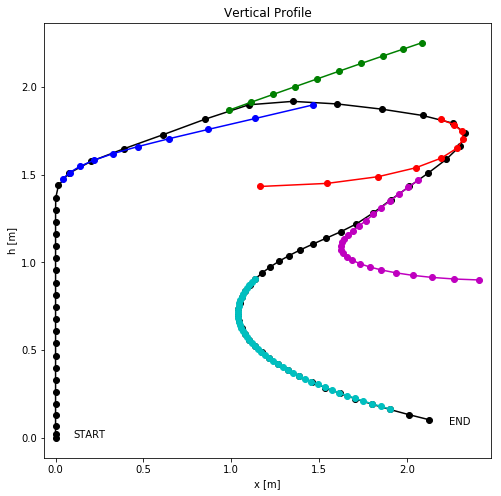

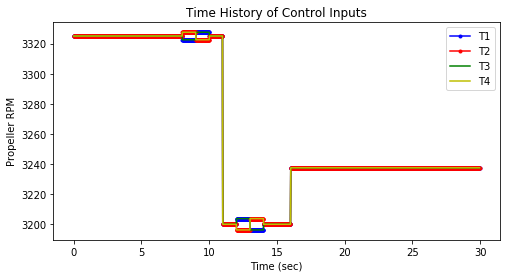

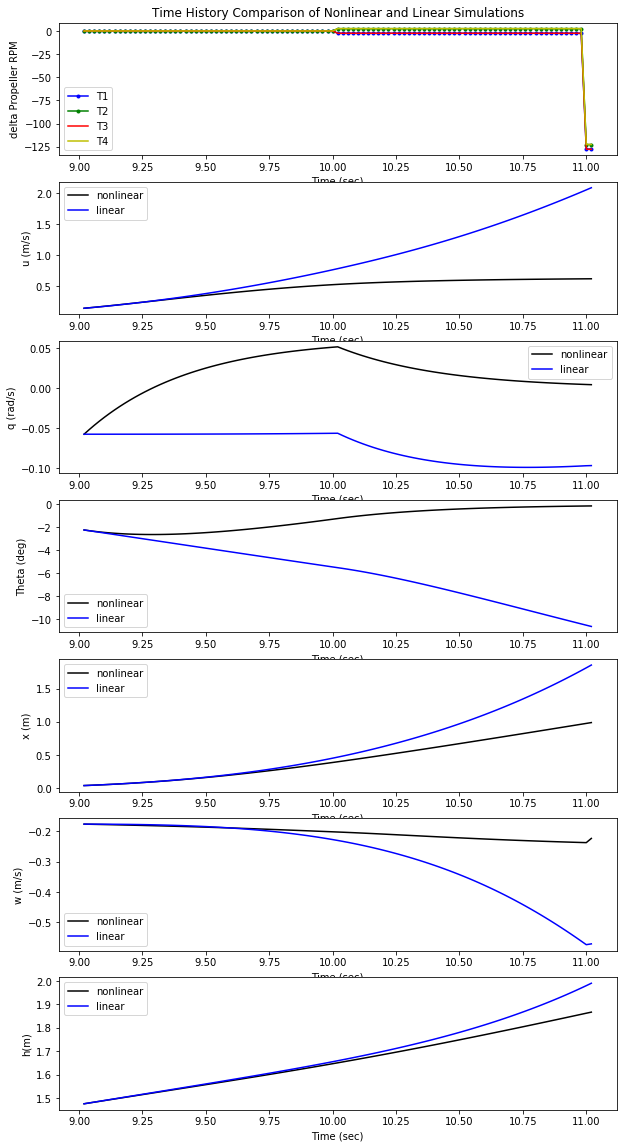

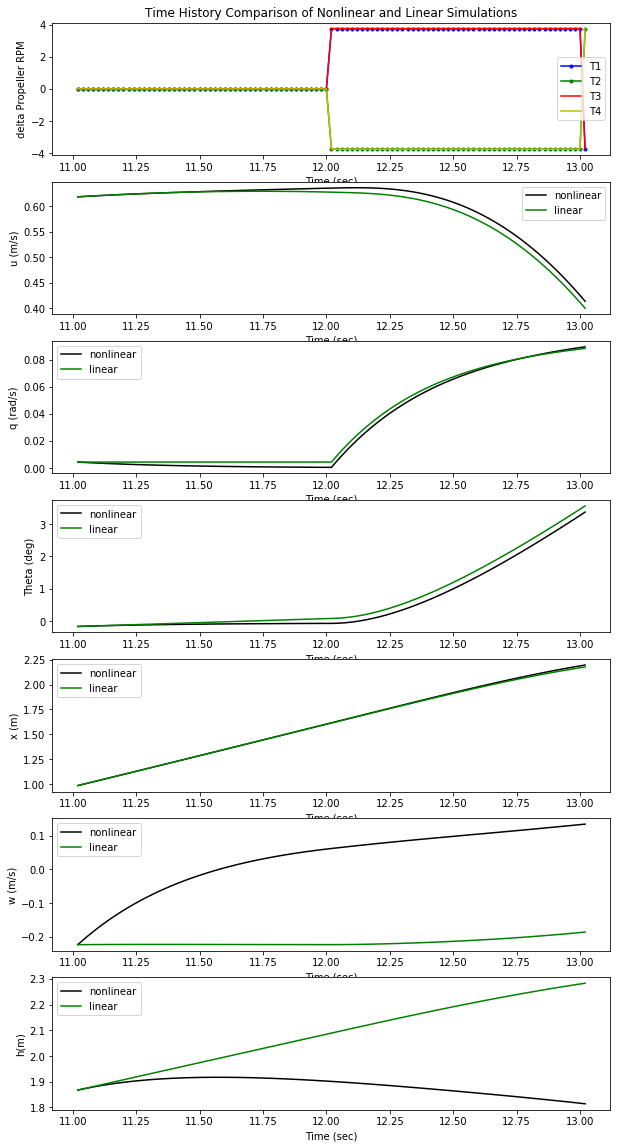

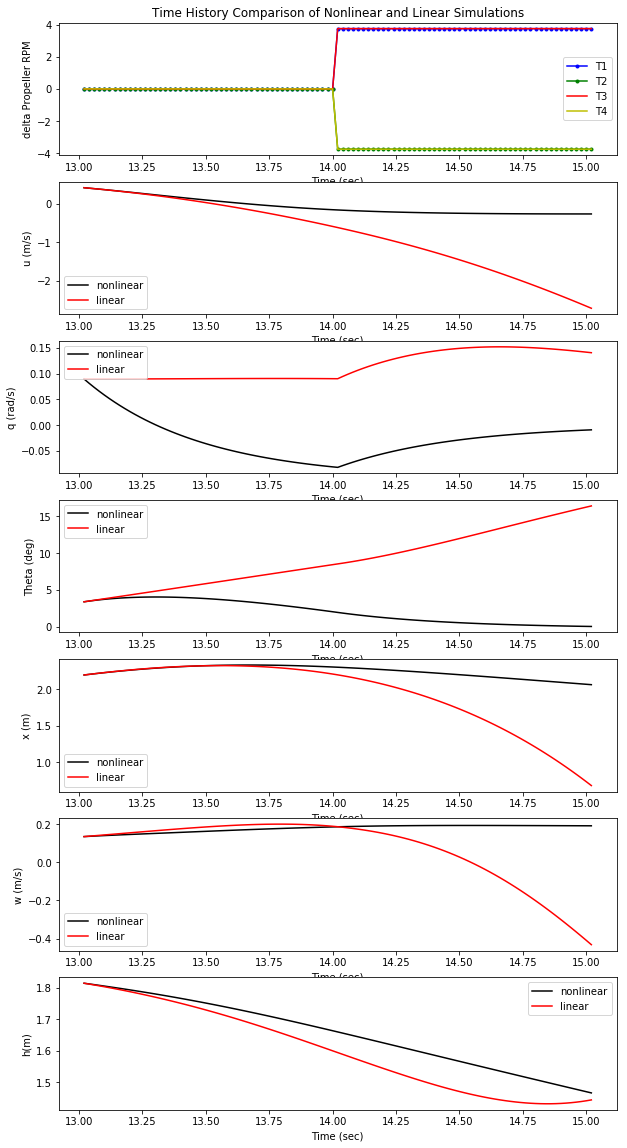

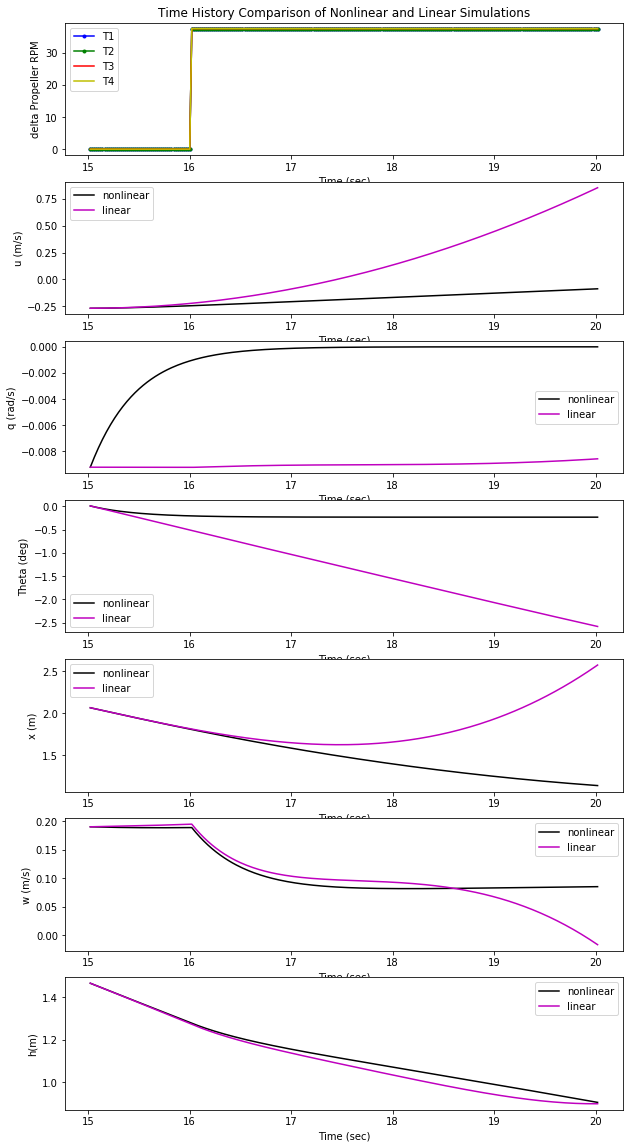

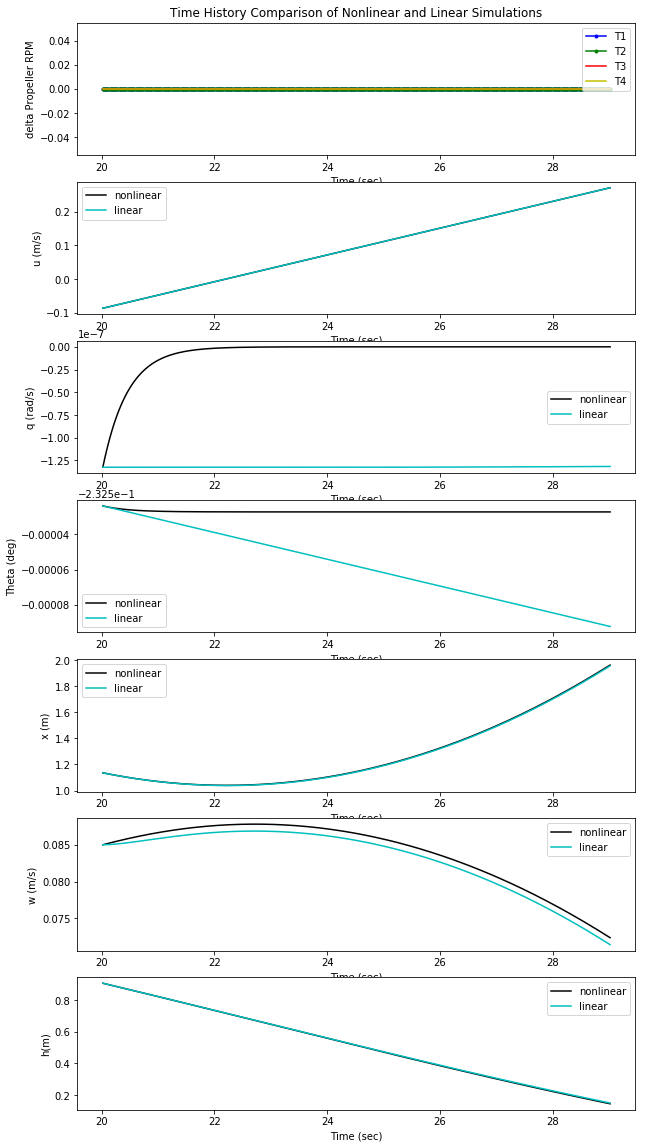

In [145]:
# Compare a selection of starting points projecting linear model 2 seconds

num_conditions = 5
t_array = [None] * num_conditions
x_linear_array = [None] * num_conditions
x_nonlinear_array = [None] * num_conditions
u_array = [None] * num_conditions

duration = 2 #sec

start_time = 9 #sec
t_array[0], x_linear_array[0], x_nonlinear_array[0], u_array[0] = get_linear_projection(start_time, duration)

start_time = 11 #sec
t_array[1], x_linear_array[1], x_nonlinear_array[1], u_array[1] = get_linear_projection(start_time, duration)

start_time = 13 #sec
t_array[2], x_linear_array[2], x_nonlinear_array[2], u_array[2] = get_linear_projection(start_time, duration)

duration = 5 #sec

start_time = 15 #sec
t_array[3], x_linear_array[3], x_nonlinear_array[3], u_array[3] = get_linear_projection(start_time, duration)

duration = 9 #sec

start_time = 20 #sec
t_array[4], x_linear_array[4], x_nonlinear_array[4], u_array[4] = get_linear_projection(start_time, duration)

plot_results(t_array, x_linear_array, x_nonlinear_array, u_array, t, x, u)



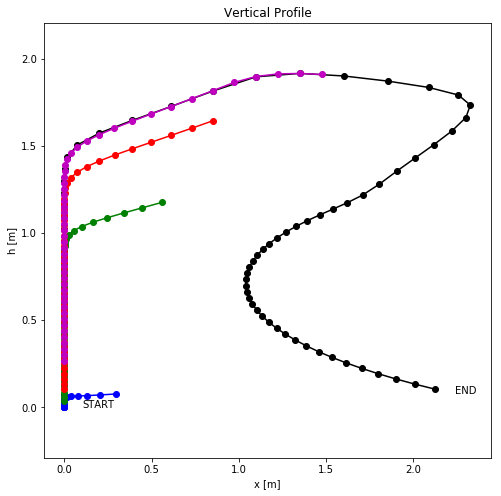

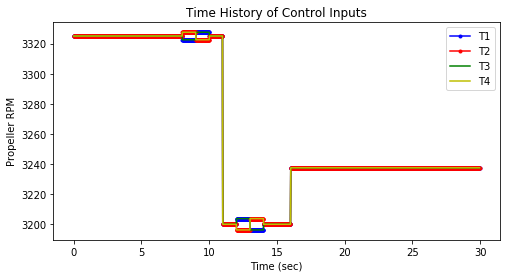

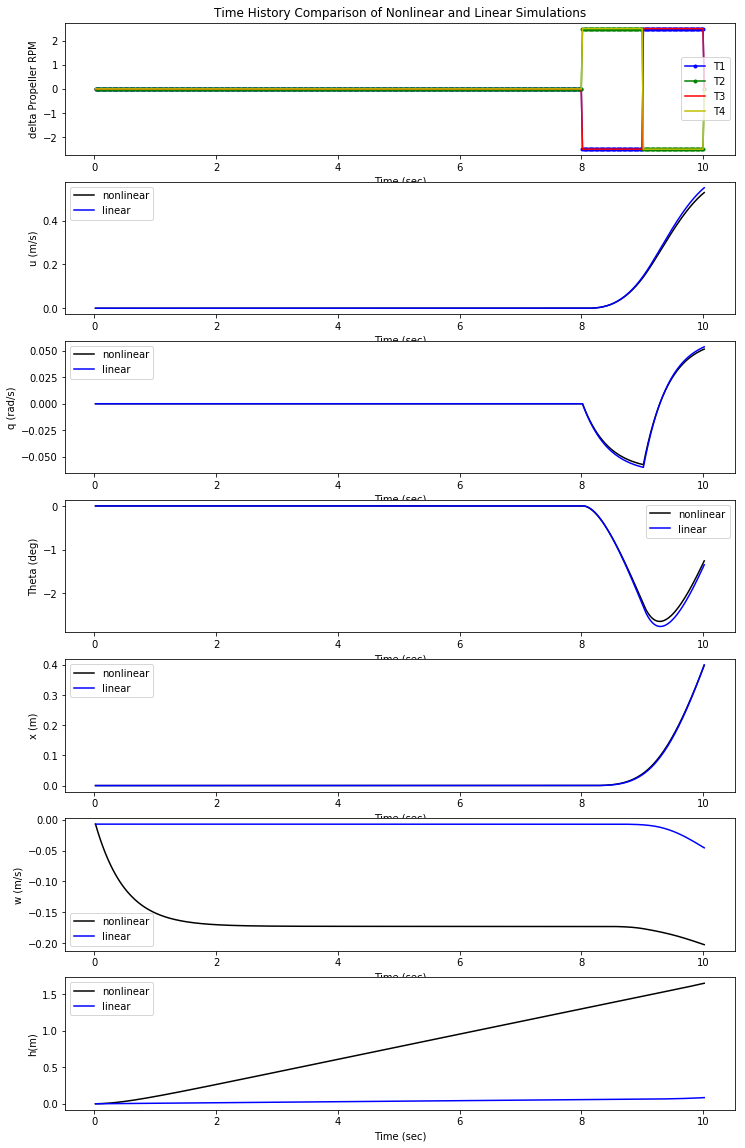

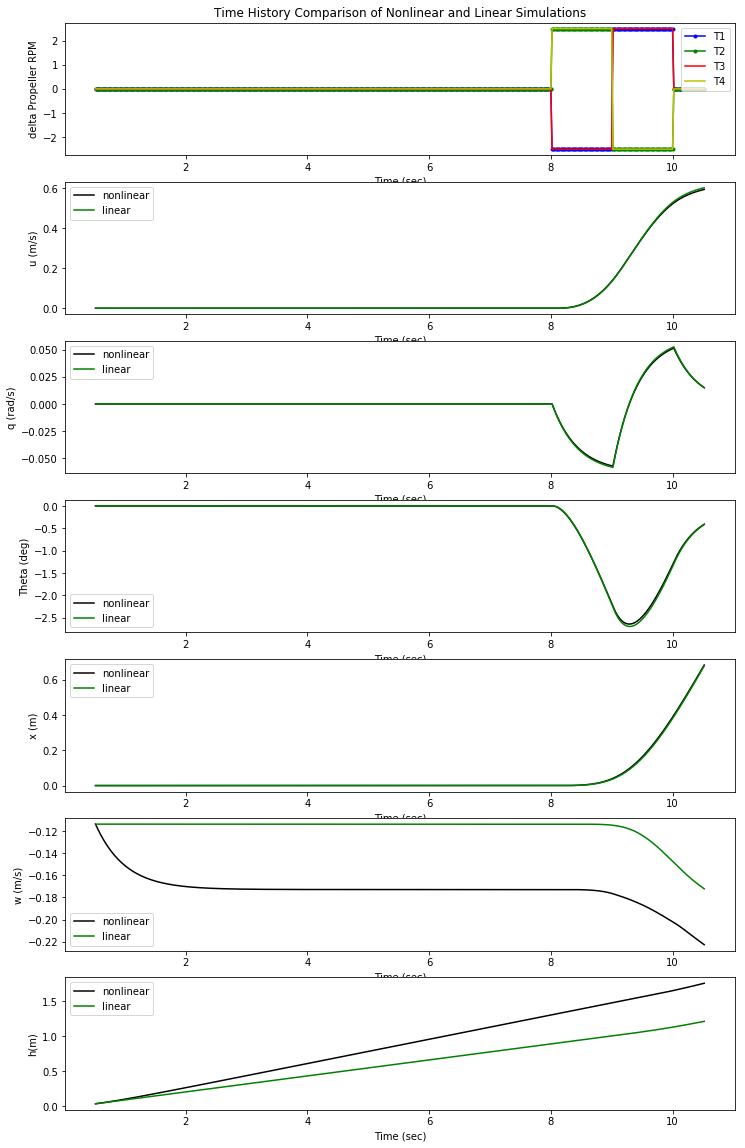

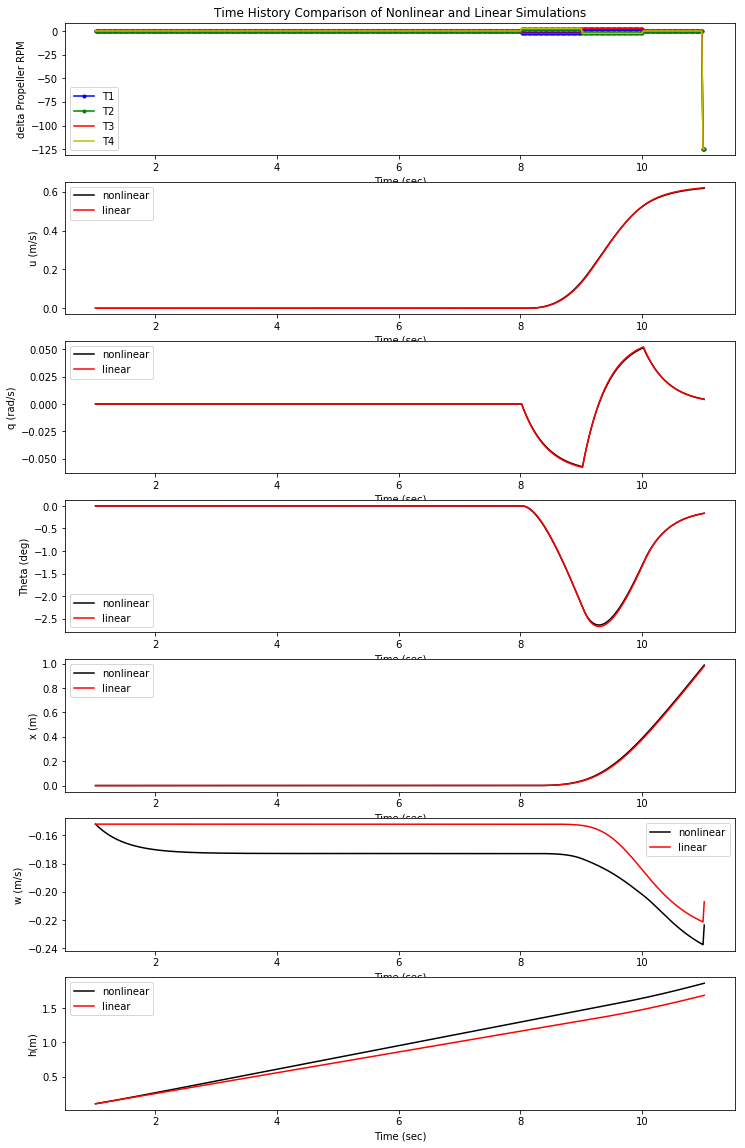

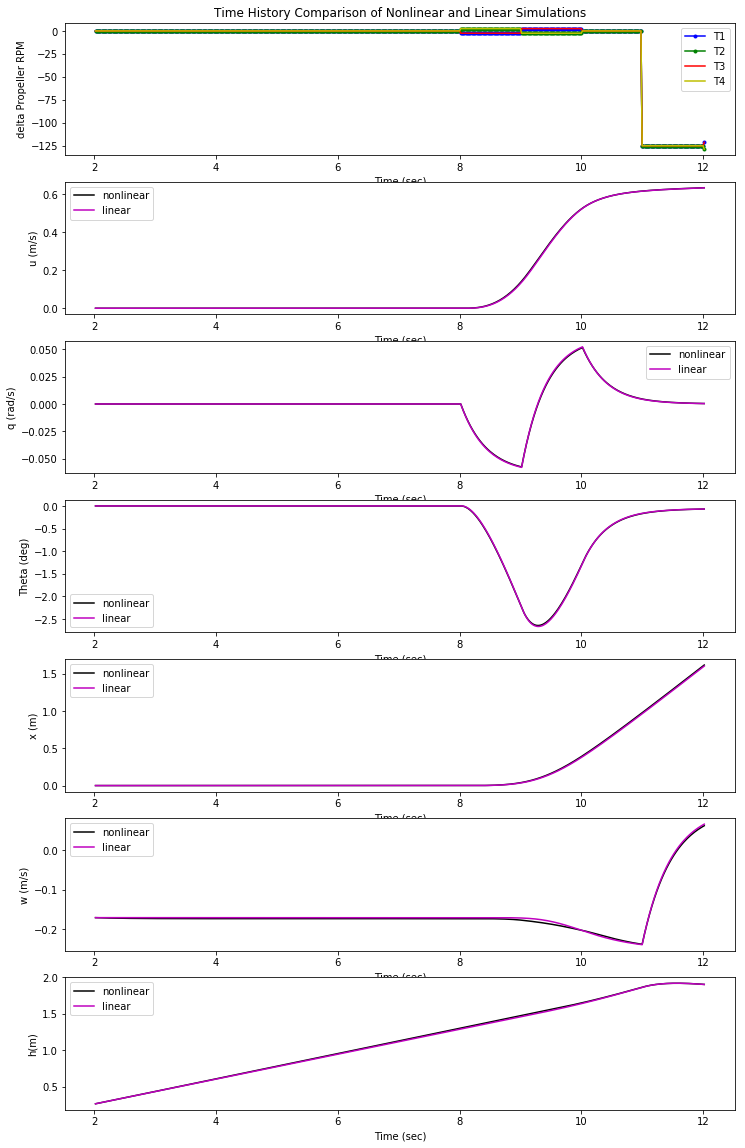

In [134]:
# Compare a selection of starting points projecting linear model 2 seconds
duration = 10 #sec

num_conditions = 4
t_array = [None] * num_conditions
x_linear_array = [None] * num_conditions
x_nonlinear_array = [None] * num_conditions
u_array = [None] * num_conditions

start_time = 0 #sec
t_array[0], x_linear_array[0], x_nonlinear_array[0], u_array[0] = get_linear_projection(start_time, duration)

start_time = 0.5 #sec
t_array[1], x_linear_array[1], x_nonlinear_array[1], u_array[1] = get_linear_projection(start_time, duration)

start_time = 1 #sec
t_array[2], x_linear_array[2], x_nonlinear_array[2], u_array[2] = get_linear_projection(start_time, duration)

start_time = 2 #sec
t_array[3], x_linear_array[3], x_nonlinear_array[3], u_array[3] = get_linear_projection(start_time, duration)

plot_results(t_array, x_linear_array, x_nonlinear_array, u_array, t, x, u)


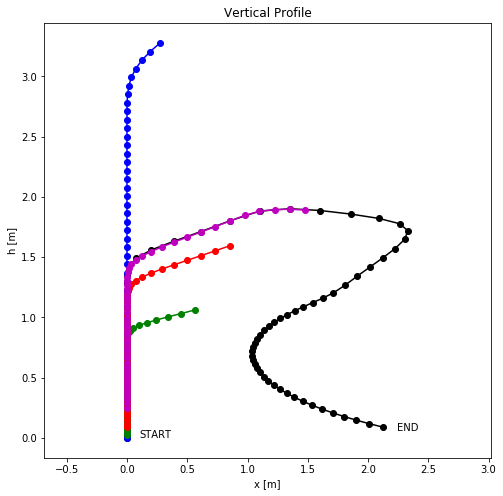

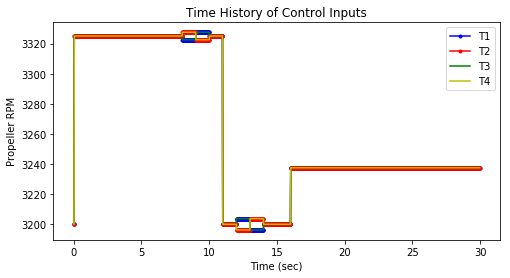

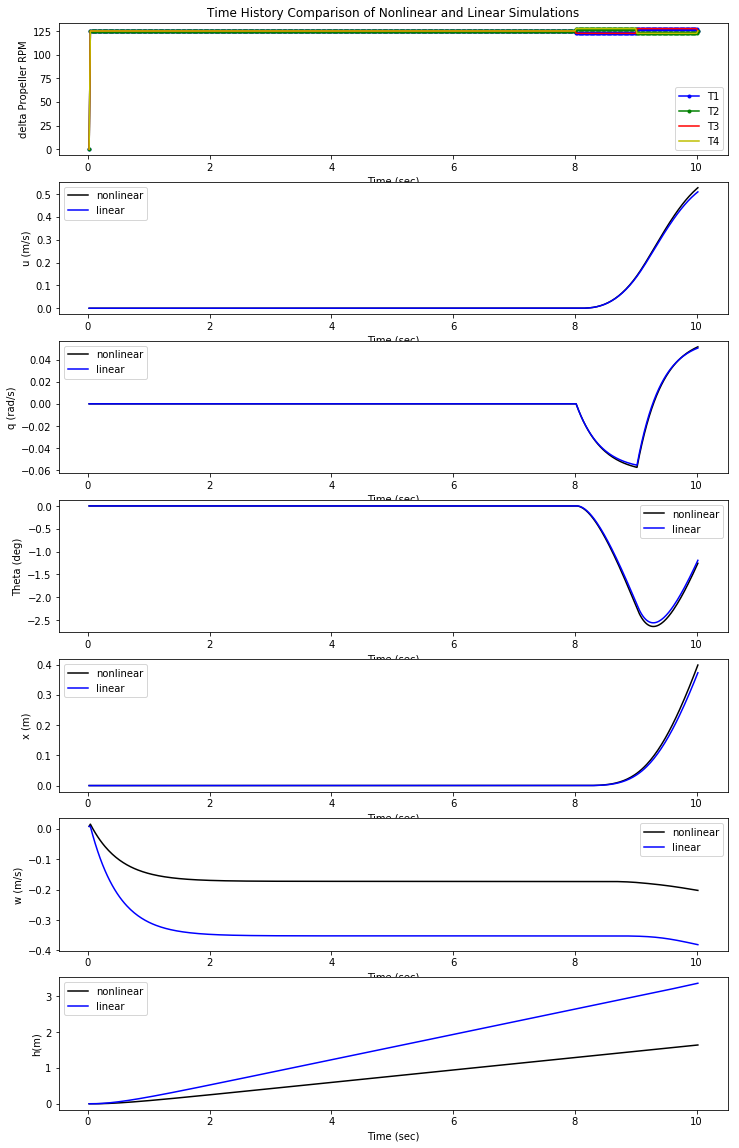

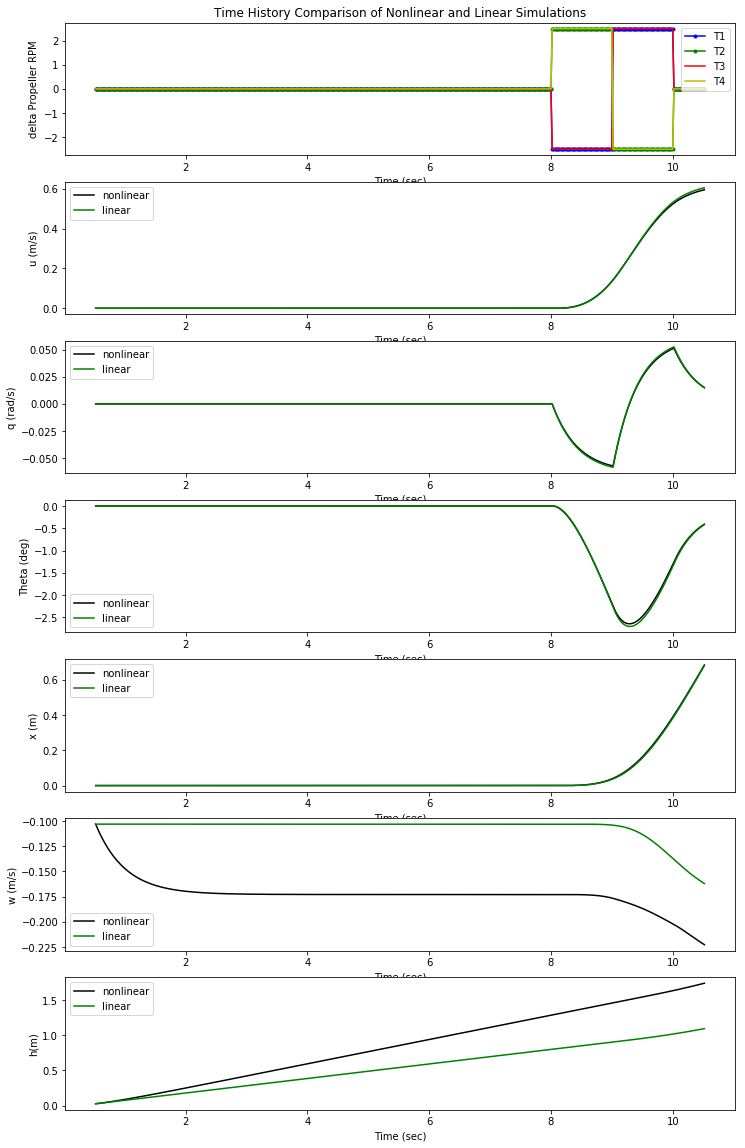

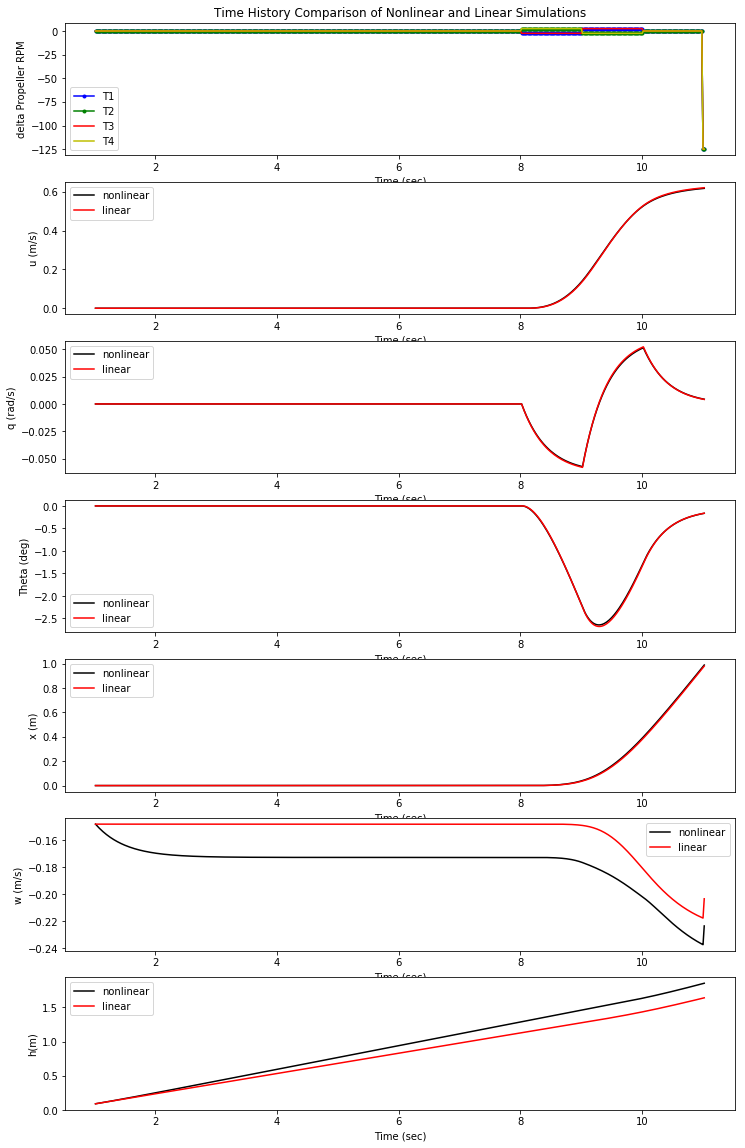

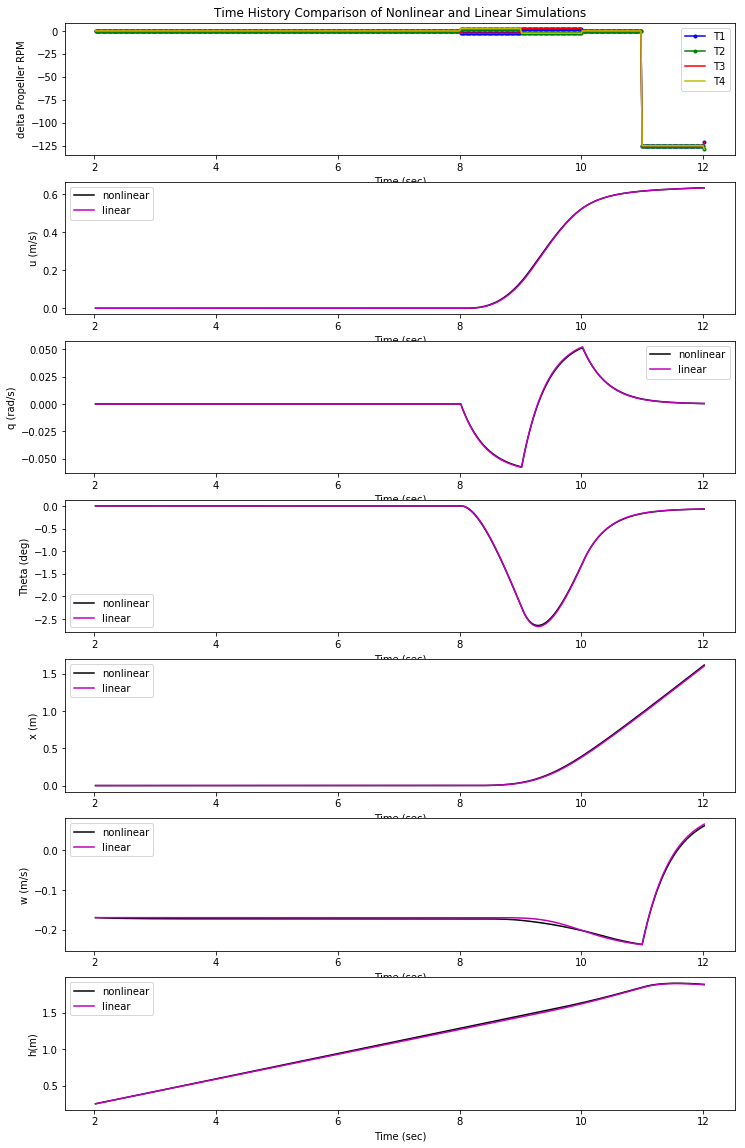

In [126]:
### USING A DIFFERENT SET OF CONTROL INPUTS (starting at 0 RPM) ###

# Compare a selection of starting points projecting linear model 2 seconds
duration = 10 #sec

num_conditions = 4
t_array = [None] * num_conditions
x_linear_array = [None] * num_conditions
x_nonlinear_array = [None] * num_conditions
u_array = [None] * num_conditions

start_time = 0 #sec
t_array[0], x_linear_array[0], x_nonlinear_array[0], u_array[0] = get_linear_projection(start_time, duration)

start_time = 0.5 #sec
t_array[1], x_linear_array[1], x_nonlinear_array[1], u_array[1] = get_linear_projection(start_time, duration)

start_time = 1 #sec
t_array[2], x_linear_array[2], x_nonlinear_array[2], u_array[2] = get_linear_projection(start_time, duration)

start_time = 2 #sec
t_array[3], x_linear_array[3], x_nonlinear_array[3], u_array[3] = get_linear_projection(start_time, duration)

plot_results(t_array, x_linear_array, x_nonlinear_array, u_array, t, x, u)

